# Simulation and comparison of dual pol and dual pol diagonal only

In [1]:
%matplotlib inline
import numpy as np
from osgeo import gdal
from osgeo.gdalconst import GDT_Float32, GA_ReadOnly

In [2]:
def make_simimage(fn,m=5,bands=9,sigma=1,alpha=0.2,beta=0.2):
    simimage = np.zeros((100**2,9))   
    ReSigma = np.zeros((3,3))
    ImSigma = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if i==j:
                ReSigma[i,j]=sigma**2
            elif i<j:
                ReSigma[i,j] = alpha*sigma**2
                ImSigma[i,j] = beta*sigma**2
            else:
                ReSigma[i,j] = alpha*sigma**2
                ImSigma[i,j] = -beta*sigma**2
    Sigma = np.mat(ReSigma +1j*ImSigma)
    C = np.linalg.cholesky(Sigma)
    for i in range(100**2):
        X = np.mat(np.random.randn(m,3))
        Y = np.mat(np.random.randn(m,3))
        Wr = X.T*X + Y.T*Y
        Wi = X.T*Y - Y.T*X
        W = (Wr - 1j*Wi)/2
        W = C*W*C.H
        simimage[i,0] = np.real(W[0,0])
        simimage[i,1] = np.real(W[0,1])
        simimage[i,2] = np.imag(W[0,1])
        simimage[i,3] = np.real(W[0,2])
        simimage[i,4] = np.imag(W[0,2])
        simimage[i,5] = np.real(W[1,1])
        simimage[i,6] = np.real(W[1,2])
        simimage[i,7] = np.imag(W[1,2])
        simimage[i,8] = np.real(W[2,2])
    driver = gdal.GetDriverByName('GTiff')    
    outDataset = driver.Create(fn,100,100,bands,GDT_Float32) 
    if bands == 9:
        for i in range(bands):
            outband = outDataset.GetRasterBand(i+1)
            outband.WriteArray(np.reshape(simimage[:,i],(100,100)),0,0) 
            outband.FlushCache()
    elif bands == 4:
         outband = outDataset.GetRasterBand(1)
         outband.WriteArray(np.reshape(simimage[:,0],(100,100)),0,0)
         outband.FlushCache()
         outband = outDataset.GetRasterBand(2)
         outband.WriteArray(np.reshape(simimage[:,1],(100,100)),0,0) 
         outband.FlushCache()
         outband = outDataset.GetRasterBand(3)
         outband.WriteArray(np.reshape(simimage[:,2],(100,100)),0,0)
         outband.FlushCache()
         outband = outDataset.GetRasterBand(4)
         outband.WriteArray(np.reshape(simimage[:,5],(100,100)),0,0)
         outband.FlushCache()
    elif bands == 3:
         outband = outDataset.GetRasterBand(1)
         outband.WriteArray(np.reshape(simimage[:,0],(100,100)),0,0)
         outband.FlushCache()
         outband = outDataset.GetRasterBand(2)
         outband.WriteArray(np.reshape(simimage[:,5],(100,100)),0,0) 
         outband.FlushCache()
         outband = outDataset.GetRasterBand(3)
         outband.WriteArray(np.reshape(simimage[:,8],(100,100)),0,0) 
         outband.FlushCache()
    elif bands == 2:
         outband = outDataset.GetRasterBand(1)
         outband.WriteArray(np.reshape(simimage[:,0],(100,100)),0,0)
         outband.FlushCache()
         outband = outDataset.GetRasterBand(2)
         outband.WriteArray(np.reshape(simimage[:,5],(100,100)),0,0)
         outband.FlushCache()
    elif bands == 1:
         outband = outDataset.GetRasterBand(1)
         outband.WriteArray(np.reshape(simimage[:,0],(100,100)),0,0)
         outband.FlushCache()
    outDataset = None    
    print 'written to %s'%fn     

### Simulate dual pol series with change in last (5th) image

In [20]:
bands = 4
m = 5
make_simimage('myimagery/simx1.tif',m=m,sigma=1.0,bands=bands)
make_simimage('myimagery/simx2.tif',m=m,sigma=1.0,bands=bands)
make_simimage('myimagery/simx3.tif',m=m,sigma=1.0,bands=bands)
make_simimage('myimagery/simx4.tif',m=m,sigma=1.0,bands=bands)
make_simimage('myimagery/simx5.tif',m=m,sigma=2.5,bands=bands)

written to myimagery/simx1.tif
written to myimagery/simx2.tif
written to myimagery/simx3.tif
written to myimagery/simx4.tif
written to myimagery/simx5.tif


### Run sequential omnibus, significance = 0.01, ENL = 5

In [26]:
!scripts/run_sar_seq.sh simx myimagery/ 5 0.01

     Multi-temporal SAR Change Detection
Wed Dec  5 16:19:21 2018
First (reference) filename:  myimagery/simx1.tif
number of images: 5
equivalent number of looks: 5.000000
significance level: 0.010000
Dual polarizaton
pre-calculating Rj and p-values ...
attempting parallel calculation ...
/usr/local/lib/python2.7/dist-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@vivo')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)
available engines [0, 1]
ell =  1 2 3 4 
elapsed time for p-value calculation: 0.142284870148
last change map written to: /home/mort/python/CRC4Docker/src/myimagery/sarseq_cmap.tif
frequency map written to: /home/mort/python/CRC4Docker/src/myimagery/sarseq_fmap.tif
bitemporal map image written to: /home/mort/python/CRC4Docker/src/myimagery/sarseq_bmap.tif
first ch

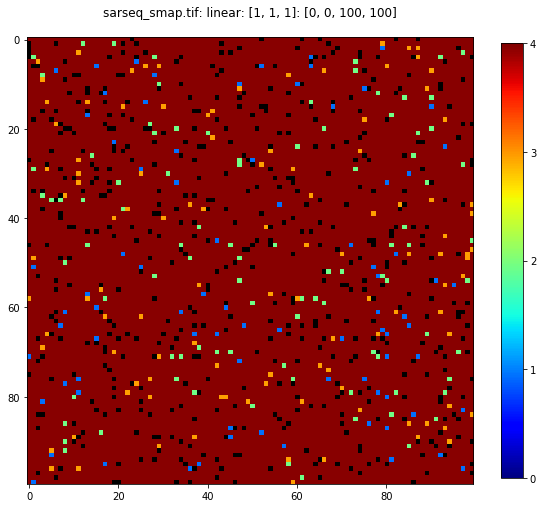

In [27]:
run scripts/dispms -f myimagery/sarseq_smap.tif -c 

### Repeat above for dual pol diagonal only 

### Count positives in each of the four intervals

In [28]:
def count(infile):
    gdal.AllRegister()             
    inDataset = gdal.Open(infile,GA_ReadOnly)     
    cols = inDataset.RasterXSize
    rows = inDataset.RasterYSize 
    bands = inDataset.RasterCount                            
    for b in range(bands):
        band = inDataset.GetRasterBand(b+1)
        data=band.ReadAsArray(0,0,cols,rows)
        print 'interval %i  positives: %f'%(b+1,np.sum(data)/255.0)
    inDataset = None
      
count('myimagery/sarseq_bmap.tif')

interval 1  positives: 81.000000
interval 2  positives: 106.000000
interval 3  positives: 131.000000
interval 4  positives: 9466.000000
